Here we take the parameters of the detector SPAD-1 (Excelitas SPCM-AQRH CD3432H) and show the effect of the temporal afterpulsing distribution. To this end, we compare two models — the first is used in the manuscript and considers afterpulses as a probabilistic event possibly occurring immediately after each dead time; the second model employs the full SPAD afterpulsing model \[1\]. We chose SPAD-1 because we already have the afterpulsing distribution measured \[2\].

* \[1\] I. Straka, J. Grygar, J. Hloušek and M. Ježek, *Counting Statistics of Actively Quenched SPADs Under Continuous Illumination*, Journal of Lightwave Technology 38, 4765 - 4771 (2020). https://doi.org/dzmt
* \[2\] I. Straka, J. Grygar, J. Hloušek and M. Ježek, https://doi.org/10.24433/CO.8487128.v1, *Counting Statistics of Actively Quenched SPADs Under Continuous Illumination*, CodeOcean capsule (2020).

In [1]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt
%matplotlib inline

# Constants

In [2]:
### TIME UNIT - 1 microsecond ###

binWidth = 81e-6 # AP histogram bin width

# precision setting - sufficient values depends on other parameters
no_iter = 20 # number of iterations
ilace_n = 3 # number of interlacing zeroes to allow finer sampling in the mean rate calculation

# SPAD-1 parameters
AP_mean = 0.002 # mean number of afterpulses
rec_time = 0.0295 # recovery time
alpha = 0.002   # twilight constant
dark_counts = 88*1e-6

# Afterpulsing distribution import

In [3]:
# discrete sampling of 'binWidth'
AP_dist = np.fromfile('afterpulsing/apDist_3432H.bin', '<f8')

# implement interlacing
binWidth /= (1+ilace_n)
apM = AP_dist.reshape((1,-1))
apM = np.concatenate((apM,np.zeros((ilace_n,len(AP_dist)))))
AP_dist = apM.T.flatten()

# Exact model definitions

See Ref. \[1\] https://doi.org/dzmt, the numerical evaluation is covered in the supplemental material.

In [4]:
# pad n zeroes to the right
def ZeroPad(ar, n):
    return np.pad(ar, (0, n), 'constant', constant_values=0)

# the integral transform from eq. (6) in Ref. [1]
# takes an array representing the overhead 'f' and returns an updated 'f'
# the overhead 'f' is discrete, so basically it is 'f(t)dt'
def OverheadIterate(f, mu, d, APmean, a, apDist):
    # AP intensity
    nuArray = apDist*APmean
    # time values
    t = np.arange(len(f))*binWidth
    # integrands
    integrand_1 = ZeroPad(f[d:], d)
    integrand_2 = (mu*binWidth + f) * np.exp(-mu*t - np.cumsum(f))
    # correlation using FFT
    corr = correlate(integrand_1,integrand_2, method='fft')[(len(f)-1):]
    res = (1-a*mu)*corr + a*mu*ZeroPad(f[d:], d) + nuArray
    return res

# calculate mean rate from 'f'
# Eqs. (28) and (29) of the supplemental material of Ref. [1]
def MeanRateFromOverhead(f, mu, dt, a):
    # time values
    t = np.arange(len(f))*binWidth
    # stationary interarrival PDF
    p_bar = (mu*binWidth + f)*np.exp(-mu*t - np.cumsum(f))
    # calculate an auxiliary term x
    x = np.dot(t,p_bar) + ((1./mu + (t[-1]+binWidth)) * \
        np.exp(-(t[-1]+binWidth)*mu - sum(f)))
    return (1./(x*(1.-a*mu) + dt))

# mean rate of the full model
def MeanRate(mu,dt,APmean,a,apDist):
    # initial f
    f = np.zeros(len(apDist), dtype=np.double)
    # recovery time expressed in bins
    dead_index = int(round(rec_time/binWidth))
    for i in range(no_iter):
        f = OverheadIterate(f, mu,dead_index,APmean,a,apDist)
    return MeanRateFromOverhead(f, mu, dt, a)

# Manuscript model definitions

In [5]:
# mean rate of the NP model
def MeanRate2(mu,dt,*args):
    return 1./(1./mu + dt)

def NonlinearityModel(fun,mu,dt,dc,APmean,a,apDist):
    ra  = fun(mu/2+dc,dt,APmean,a,apDist)
    rab = fun(mu+dc,dt,APmean,a,apDist)
    return (rab,(2*ra/rab)-1.)

def InvRate2(r,dt):
    return 1./(1./r-dt)

# Calculations

In [6]:
### TAKES LONGER TO EVALUATE ###

# incident rate sampling
rlogRates = np.linspace(-5.,2.,100)
rvals = np.power(10.,rlogRates)

# evaluate the full model first
fullmodel = [NonlinearityModel(MeanRate,r,rec_time,dark_counts,AP_mean,alpha,AP_dist) for r in rvals]
fullmodel = np.array(fullmodel)

In [7]:
# to compare with the full model, we need to match the AB detection rates
# calculate R/exp(-AP_mean) as a modified input rate for the NP model
input_rates = InvRate2(fullmodel[:,0], rec_time-alpha*np.exp(-AP_mean)) - dark_counts/np.exp(-AP_mean)

models = [
    [NonlinearityModel(MeanRate2,
                       r,
                       rec_time-alpha*np.exp(-AP_mean),
                       dark_counts/np.exp(-AP_mean),
                       None,None,None
                      ) for r in input_rates],
    fullmodel
    ]
models = np.array(models).transpose(0,2,1)

In [8]:
# test if the rate values match (x-axis values in the graph)
np.all(
    np.isclose( models[0,0], models[1,0],
                rtol=0, atol=1e-14)
)

True

# Plot

In [9]:
par_string = f'''\
$R_0$ = {dark_counts*1e6:.0f} cps
$\\tau_\\mathrm{{NP}}$ = {rec_time*1e3} ns
$\\langle n_\\mathrm{{AP}} \\rangle$ = {AP_mean}
$\\alpha$ = {alpha*1e3} ns\
'''

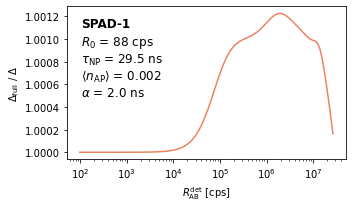

In [10]:
fig = plt.figure(figsize=(5,3))
plt.xscale('log')
plt.plot(models[0,0]*1e6, models[1,1]/models[0,1], c='#eb8360')
plt.xlabel(r'$R^\mathrm{det}_\mathrm{AB}$ [cps]')
plt.ylabel(r'$\Delta_\mathrm{full}~/~\Delta$')
plt.annotate(r'SPAD-1', xy=[0.05,0.93], va='top',
             xycoords='axes fraction', size=12, weight='bold')
plt.annotate(par_string, xy=[0.05,0.82], va='top',
             xycoords='axes fraction', size=12)
plt.tight_layout()
plt.show()